# Notebook for testing of preprocessing script

In [19]:
import SimpleITK as sitk
# from downloaddata import fetch_data as fdata
from extensies import preprocessing as my
from extensies import normalization
import skimage.feature as ft
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

### Load findings and informations about images

In [2]:
df_images = pd.read_csv('../../data/info/ProstateX-Images-Train.csv')
df_findings = pd.read_csv('../../data/info/ProstateX-Findings-Train.csv')
df_ktrans = pd.read_csv('../../data/info/ProstateX-Images-KTrans-Train.csv')

### Script:
images are not stored

In [6]:
root_path = '../../data/PROSTATEx'
path_to_data = '../../data/'
modality = 't2tsetra'
new_spacing = (1,1,1)
orientation = 't'
patch_size = (20,20,1)

target_path = os.path.join(path_to_data,modality,orientation, 
                            str(patch_size[0]) + 'x' + str(patch_size[1]) + 'x' + str(patch_size[2]))

# x = 1.5
# offsets = [[0,0,0],[-x,x,x],[x,x,x],[-x,-x,x],[x,-x,x],
#             [-x,x,0],[x,x,0],[-x,-x,0],[x,-x,0],[-x,x,-x],[x,x,-x],[-x,-x,-x],[x,-x,-x]]
offsets = [[0,0,0]]

images = []
new_df = pd.DataFrame(columns = ['ProxID','fid','zone','ClinSig','name'])

# findings = df_findings.drop(df_findings.index[[33,34,35,36,37,154,84,110,131,145,176,179,215,230,264,265,268,275,292,304]])
# findings = df_findings.drop(df_findings.index[[33,34,35,36,37,154,44,45,84,110,131,145,176,179,215,230,264,265,268,275,292,304]])
findings = df_findings.drop(df_findings.index[[33,34,35,36,37,154,5,44,45,46,64,
                                               81,84,87,110,114,131,145,162,176,179,190,193,215,230,246,264,265,268,275,292,304,325]])
findings = findings[findings['zone'] != 'SV']

# iterate throught all findings
index = 0
for idx,row in findings[:5].iterrows():
    print(idx)

    if modality == 'ktrans':
        path_to_image = my.get_ktrans_path(row['ProxID'],path_to_data)
        image = sitk.ReadImage(path_to_image)
    else:
        path_to_image = my.get_path(row['ProxID'], modality, root_path)
        fixed_series_filenames = sitk.ImageSeriesReader_GetGDCMSeriesFileNames(path_to_image)
        image = sitk.ReadImage(fixed_series_filenames)

    # fit normalizer
    normalizer = normalization.ScaleNormalization()
    normalizer.fit(sitk.GetArrayFromImage(image))
    # resample image to same spacing in all directions
    image = my.resample_image_to_spacing(image, new_spacing, sitk.sitkLinear)
    # extract region of interest
    center = [float(x) for x in row['pos'].split()] 
    for i,offset in enumerate(offsets):
        volume  = my.get_patch_from_image(image, patch_size, center, orientation)
        # normalise data
        volume = normalizer.normalise(volume)

        #save image
        file_name = row['ProxID']+'_'+str(index)+'_'+row['zone']+'.nii'
        new_df.loc[index] = row[['ProxID','fid','zone','ClinSig']]
        new_df.loc[index,'name'] = file_name
        new_df.loc[index,'ID'] = idx
        new_df.loc[index,'normalization'] = normalizer.name
        print(volume.shape)
        images.append(volume)

        index += 1

# new_df.to_csv(os.path.join(target_path,'info.csv'))

0
4-t2tsetra-00702
(20, 20)
1
10-t2tsetra-17541
(20, 20)
2
4-t2tsetra-44920
(20, 20)
3
4-t2tsetra-44920
(20, 20)
4
3-t2tsetra-30967
(20, 20)


In [9]:
images = np.array(images)
images.shape

(5, 20, 20)

## function to automize loading

In [12]:
def get_images(modality = 't2tsetra', orientation = 't'):
    root_path = '../../data/PROSTATEx'
    path_to_data = '../../data/'
    new_spacing = (1,1,1)
    patch_size = (20,20,1)
    images = []


    target_path = os.path.join(path_to_data,modality,orientation, 
                                str(patch_size[0]) + 'x' + str(patch_size[1]) + 'x' + str(patch_size[2]))

    # x = 1.5
    # offsets = [[0,0,0],[-x,x,x],[x,x,x],[-x,-x,x],[x,-x,x],
    #             [-x,x,0],[x,x,0],[-x,-x,0],[x,-x,0],[-x,x,-x],[x,x,-x],[-x,-x,-x],[x,-x,-x]]
    offsets = [[0,0,0]]



    new_df = pd.DataFrame(columns = ['ProxID','fid','zone','ClinSig','name'])
    roi_volumes = []
    # findings = df_findings.drop(df_findings.index[[33,34,35,36,37,154,84,110,131,145,176,179,215,230,264,265,268,275,292,304]])
    # findings = df_findings.drop(df_findings.index[[33,34,35,36,37,154,44,45,84,110,131,145,176,179,215,230,264,265,268,275,292,304]])
    findings = df_findings.drop(df_findings.index[[33,34,35,36,37,154,5,44,45,46,64,
                                                   81,84,87,110,114,131,145,162,176,179,190,193,215,230,246,264,265,268,275,292,304,325]])
    findings = findings[findings['zone'] != 'SV']

    # iterate throught all findings
    index = 0
    for idx,row in findings.iterrows():

        if modality == 'ktrans':
            path_to_image = my.get_ktrans_path(row['ProxID'],path_to_data)
            image = sitk.ReadImage(path_to_image)
        else:
            path_to_image = my.get_path(row['ProxID'], modality, root_path)
            fixed_series_filenames = sitk.ImageSeriesReader_GetGDCMSeriesFileNames(path_to_image)
            image = sitk.ReadImage(fixed_series_filenames)

        # fit normalizer
        normalizer = normalization.ScaleNormalization()
        normalizer.fit(sitk.GetArrayFromImage(image))
        # resample image to same spacing in all directions
        image = my.resample_image_to_spacing(image, new_spacing, sitk.sitkLinear)

        # extract region of interest
        center = [float(x) for x in row['pos'].split()] 
        for i,offset in enumerate(offsets):
            volume  = my.get_patch_from_image(image, patch_size, center, orientation)
            # normalise data
            volume = normalizer.normalise(volume)

            #save image
            file_name = row['ProxID']+'_'+str(index)+'_'+row['zone']+'.nii'
            new_df.loc[index] = row[['ProxID','fid','zone','ClinSig']]
            new_df.loc[index,'name'] = file_name
            new_df.loc[index,'ID'] = idx
            new_df.loc[index,'normalization'] = normalizer.name

            images.append(volume)

            index += 1
    images = np.array(images)
    print("shape: ", images.shape)
    return images,new_df

## Read images from three orientations

In [11]:
imagest = get_images('adc','t')

7-ep2ddifftraDYNDISTADC-48780
8-ep2ddifftraDYNDISTMIXADC-33954
7-ep2ddifftraDYNDISTADC-78067
7-ep2ddifftraDYNDISTADC-78067
6-ep2ddifftraDYNDISTADC-83547
7-ep2ddifftraDYNDISTMIXADC-91158
7-ep2ddifftraDYNDISTMIXADC-16270
7-ep2ddifftraDYNDISTMIXADC-16270
7-ep2ddifftraDYNDISTMIXADC-16270
7-ep2ddifftraDYNDISTADC-34068
7-ep2ddifftraDYNDISTADC-34068
8-ep2ddifftraDYNDISTADC-05734
8-ep2ddifftraDYNDISTADC-77513
7-ep2ddifftraDYNDISTADC-30502
8-ep2ddifftraDYNDISTADC-19362
8-ep2ddifftraDYNDISTADC-49862
8-ep2ddifftraDYNDISTADC-33105
8-ep2ddifftraDYNDISTADC-33105
7-ep2ddifftraDYNDISTMIXADC-49879
7-ep2ddifftraDYNDISTMIXADC-40369
7-ep2ddifftraDYNDISTMIXADC-68133
7-ep2ddifftraDYNDISTADC-29603
7-ep2ddifftraDYNDISTADC-72735
7-ep2ddifftraDYNDISTADC-31899
7-ep2ddifftraDYNDISTMIXADC-95747
7-ep2ddifftraDYNDISTADC-56755
7-ep2ddifftraDYNDISTADC-81901
7-ep2ddifftraDYNDISTADC-81901
7-ep2ddifftraDYNDISTADC-50533
7-ep2ddifftraDYNDISTADC-11919
7-ep2ddifftraDYNDISTADC-11919
7-ep2ddifftraDYNDISTADC-87695
7-ep2ddifftra

7-ep2ddifftraDYNDISTADC-17685
7-ep2ddifftraDYNDISTADC-74412
7-ep2ddifftraDYNDISTADC-01801
7-ep2ddifftraDYNDISTADC-01801
11-ep2ddifftraDYNDISTADC-46731
11-ep2ddifftraDYNDISTADC-46731
10-ADCS32-13343
7-ep2ddifftraDYNDISTADC-37107
7-ep2ddifftraDYNDISTADC-37107
7-ep2ddifftraDYNDISTADC-04182
7-ep2ddifftraDYNDISTADC-04182
7-ep2ddifftraDYNDISTADC-04182
7-ep2ddifftraDYNDISTADC-04182
7-ep2ddifftraDYNDISTADC-35731
7-ep2ddifftraDYNDISTADC-23818
7-ep2ddifftraDYNDISTADC-66828
7-ep2ddifftraDYNDISTADC-66828
7-ep2ddifftraDYNDISTADC-66828
7-ep2ddifftraDYNDISTADC-56552
7-ep2ddifftraDYNDISTADC-29009
8-diffusie-3Scan-4bvalfsADC-44250
8-diffusie-3Scan-4bvalfsADC-44250
9-diffusie-3Scan-4bvalfsADC-58422
9-diffusie-3Scan-4bvalfsADC-58422
7-diffusie-3Scan-4bvalfsADC-93612
7-diffusie-3Scan-4bvalfsADC-93612
7-diffusie-3Scan-4bvalfsADC-93156
7-diffusie-3Scan-4bvalfsADC-93156
shape:  (296, 20, 20)


In [13]:
imagesa = get_images('adc','a')

7-ep2ddifftraDYNDISTADC-48780
8-ep2ddifftraDYNDISTMIXADC-33954
7-ep2ddifftraDYNDISTADC-78067
7-ep2ddifftraDYNDISTADC-78067
6-ep2ddifftraDYNDISTADC-83547
7-ep2ddifftraDYNDISTMIXADC-91158
7-ep2ddifftraDYNDISTMIXADC-16270
7-ep2ddifftraDYNDISTMIXADC-16270
7-ep2ddifftraDYNDISTMIXADC-16270
7-ep2ddifftraDYNDISTADC-34068
7-ep2ddifftraDYNDISTADC-34068
8-ep2ddifftraDYNDISTADC-05734
8-ep2ddifftraDYNDISTADC-77513
7-ep2ddifftraDYNDISTADC-30502
8-ep2ddifftraDYNDISTADC-19362
8-ep2ddifftraDYNDISTADC-49862
8-ep2ddifftraDYNDISTADC-33105
8-ep2ddifftraDYNDISTADC-33105
7-ep2ddifftraDYNDISTMIXADC-49879
7-ep2ddifftraDYNDISTMIXADC-40369
7-ep2ddifftraDYNDISTMIXADC-68133
7-ep2ddifftraDYNDISTADC-29603
7-ep2ddifftraDYNDISTADC-72735
7-ep2ddifftraDYNDISTADC-31899
7-ep2ddifftraDYNDISTMIXADC-95747
7-ep2ddifftraDYNDISTADC-56755
7-ep2ddifftraDYNDISTADC-81901
7-ep2ddifftraDYNDISTADC-81901
7-ep2ddifftraDYNDISTADC-50533
7-ep2ddifftraDYNDISTADC-11919
7-ep2ddifftraDYNDISTADC-11919
7-ep2ddifftraDYNDISTADC-87695
7-ep2ddifftra

7-ep2ddifftraDYNDISTADC-01801
7-ep2ddifftraDYNDISTADC-01801
11-ep2ddifftraDYNDISTADC-46731
11-ep2ddifftraDYNDISTADC-46731
10-ADCS32-13343
7-ep2ddifftraDYNDISTADC-37107
7-ep2ddifftraDYNDISTADC-37107
7-ep2ddifftraDYNDISTADC-04182
7-ep2ddifftraDYNDISTADC-04182
7-ep2ddifftraDYNDISTADC-04182
7-ep2ddifftraDYNDISTADC-04182
7-ep2ddifftraDYNDISTADC-35731
7-ep2ddifftraDYNDISTADC-23818
7-ep2ddifftraDYNDISTADC-66828
7-ep2ddifftraDYNDISTADC-66828
7-ep2ddifftraDYNDISTADC-66828
7-ep2ddifftraDYNDISTADC-56552
7-ep2ddifftraDYNDISTADC-29009
8-diffusie-3Scan-4bvalfsADC-44250
8-diffusie-3Scan-4bvalfsADC-44250
9-diffusie-3Scan-4bvalfsADC-58422
9-diffusie-3Scan-4bvalfsADC-58422
7-diffusie-3Scan-4bvalfsADC-93612
7-diffusie-3Scan-4bvalfsADC-93612
7-diffusie-3Scan-4bvalfsADC-93156
7-diffusie-3Scan-4bvalfsADC-93156
shape:  (296, 20, 20)


In [14]:
imagess = get_images('adc','s')

7-ep2ddifftraDYNDISTADC-48780
8-ep2ddifftraDYNDISTMIXADC-33954
7-ep2ddifftraDYNDISTADC-78067
7-ep2ddifftraDYNDISTADC-78067
6-ep2ddifftraDYNDISTADC-83547
7-ep2ddifftraDYNDISTMIXADC-91158
7-ep2ddifftraDYNDISTMIXADC-16270
7-ep2ddifftraDYNDISTMIXADC-16270
7-ep2ddifftraDYNDISTMIXADC-16270
7-ep2ddifftraDYNDISTADC-34068
7-ep2ddifftraDYNDISTADC-34068
8-ep2ddifftraDYNDISTADC-05734
8-ep2ddifftraDYNDISTADC-77513
7-ep2ddifftraDYNDISTADC-30502
8-ep2ddifftraDYNDISTADC-19362
8-ep2ddifftraDYNDISTADC-49862
8-ep2ddifftraDYNDISTADC-33105
8-ep2ddifftraDYNDISTADC-33105
7-ep2ddifftraDYNDISTMIXADC-49879
7-ep2ddifftraDYNDISTMIXADC-40369
7-ep2ddifftraDYNDISTMIXADC-68133
7-ep2ddifftraDYNDISTADC-29603
7-ep2ddifftraDYNDISTADC-72735
7-ep2ddifftraDYNDISTADC-31899
7-ep2ddifftraDYNDISTMIXADC-95747
7-ep2ddifftraDYNDISTADC-56755
7-ep2ddifftraDYNDISTADC-81901
7-ep2ddifftraDYNDISTADC-81901
7-ep2ddifftraDYNDISTADC-50533
7-ep2ddifftraDYNDISTADC-11919
7-ep2ddifftraDYNDISTADC-11919
7-ep2ddifftraDYNDISTADC-87695
7-ep2ddifftra

7-ep2ddifftraDYNDISTADC-01801
7-ep2ddifftraDYNDISTADC-01801
11-ep2ddifftraDYNDISTADC-46731
11-ep2ddifftraDYNDISTADC-46731
10-ADCS32-13343
7-ep2ddifftraDYNDISTADC-37107
7-ep2ddifftraDYNDISTADC-37107
7-ep2ddifftraDYNDISTADC-04182
7-ep2ddifftraDYNDISTADC-04182
7-ep2ddifftraDYNDISTADC-04182
7-ep2ddifftraDYNDISTADC-04182
7-ep2ddifftraDYNDISTADC-35731
7-ep2ddifftraDYNDISTADC-23818
7-ep2ddifftraDYNDISTADC-66828
7-ep2ddifftraDYNDISTADC-66828
7-ep2ddifftraDYNDISTADC-66828
7-ep2ddifftraDYNDISTADC-56552
7-ep2ddifftraDYNDISTADC-29009
8-diffusie-3Scan-4bvalfsADC-44250
8-diffusie-3Scan-4bvalfsADC-44250
9-diffusie-3Scan-4bvalfsADC-58422
9-diffusie-3Scan-4bvalfsADC-58422
7-diffusie-3Scan-4bvalfsADC-93612
7-diffusie-3Scan-4bvalfsADC-93612
7-diffusie-3Scan-4bvalfsADC-93156
7-diffusie-3Scan-4bvalfsADC-93156
shape:  (296, 20, 20)


## show images

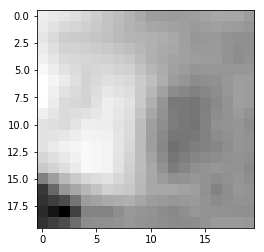

In [15]:
plt.imshow(imagest[0][0],cmap = 'gray')


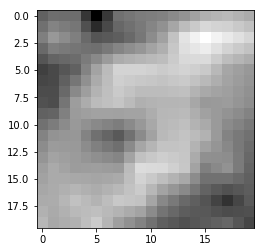

In [16]:
plt.imshow(imagesa[0][0],cmap = 'gray')

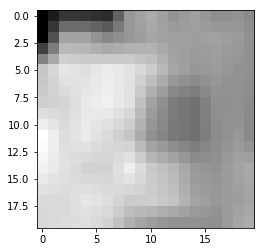

In [17]:
plt.imshow(imagess[0][0],cmap = 'gray')

## Local binary pathern

In [22]:

METHOD = 'default'
lbp = ft.local_binary_pattern(imagest[0][0], 16, 2, METHOD)

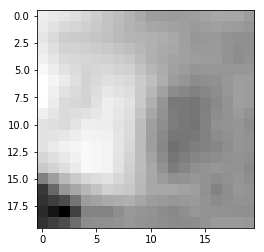

In [23]:
plt.imshow(imagest[0][0],cmap = 'gray')

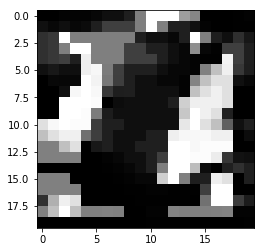

In [24]:
plt.imshow(lbp,cmap = 'gray')